In [97]:
from my_utils.base_data_handler import BaseDataHandler
handler = BaseDataHandler('food_time_delivery_clean.csv')

In [98]:
handler.df.describe()

,delivery_person_id,delivery_person_age,delivery_person_ratings,restaurant_latitude,restaurant_longitude,delivery_location_latitude,delivery_location_longitude,temperature,humidity,distance_km,target
count,9025.000000,9025.000000,9025.000000,9025.000000,9025.000000,9025.000000,9025.000000,9025.000000,9025.000000,9025.000000,9025.000000
mean,625.934404,29.516011,4.626571,17.093751,70.908555,17.102174,71.065312,22.622211,64.594349,14.278103,55.015109
std,326.979056,5.691110,0.318861,7.323503,19.965164,7.381751,19.836355,3.356099,15.376625,8.374054,27.273810
min,0.000000,15.000000,1.000000,0.002232,0.007317,0.000224,0.000732,6.770000,27.000000,1.550000,0.000000
25%,321.000000,25.000000,4.500000,12.337978,73.169083,12.441072,73.250937,19.940000,52.000000,7.600000,34.450000
50%,582.000000,29.000000,4.700000,18.539299,75.897429,18.590963,75.978497,22.860000,65.000000,13.400000,50.890000
75%,937.000000,34.000000,4.800000,22.727021,78.011544,22.778163,78.067553,25.000000,73.000000,19.590000,71.140000
max,1133.000000,50.000000,6.000000,30.914057,88.433452,31.054057,88.563452,29.050000,94.000000,59.840000,166.390000


In [99]:
handler.df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9025 entries, 0 to 9024
Data columns (total 33 columns):
 #   Column                                Non-Null Count  Dtype  
---  ------                                --------------  -----  
 0   delivery_person_id                    9025 non-null   int64  
 1   delivery_person_age                   9025 non-null   int64  
 2   delivery_person_ratings               9025 non-null   float64
 3   restaurant_latitude                   9025 non-null   float64
 4   restaurant_longitude                  9025 non-null   float64
 5   delivery_location_latitude            9025 non-null   float64
 6   delivery_location_longitude           9025 non-null   float64
 7   temperature                           9025 non-null   float64
 8   humidity                              9025 non-null   float64
 9   distance_km                           9025 non-null   float64
 10  target                                9025 non-null   float64
 11  type_of_order_buf

In [100]:
from math import radians, sin, cos, sqrt, atan2

def haversine(lat1, lon1, lat2, lon2):
    R = 6371  # Earth radius in km
    lat1, lon1, lat2, lon2 = map(radians, [lat1, lon1, lat2, lon2])
    dlat = lat2 - lat1
    dlon = lon2 - lon1
    a = sin(dlat/2)**2 + cos(lat1) * cos(lat2) * sin(dlon/2)**2
    c = 2 * atan2(sqrt(a), sqrt(1-a))
    return R * c

handler.try_add_col('haversine_km', lambda x: haversine(
    x['restaurant_latitude'], x['restaurant_longitude'],
    x['delivery_location_latitude'], x['delivery_location_longitude']))
handler.try_add_col('route_efficiency', lambda x: x['distance_km']/x['haversine_km'])
handler.df['route_efficiency'] = handler.df['distance_km'] / handler.df['haversine_km']
# Values > 1 indicate indirect route

In [101]:

# Vehicle speed capability (hypothetical)
handler.df['vehicle_speed_score'] = (
    handler.df['type_of_vehicle_motorcycle'] * 1.0 +    # Fastest
    handler.df['type_of_vehicle_scooter'] * 0.7 +       # Medium
    handler.df['type_of_vehicle_electric_scooter'] * 0.5  # Slowest
)

# Traffic severity score
handler.df['traffic_score'] = (
    handler.df['traffic_level_very_high'] * 4 +
    handler.df['traffic_level_high'] * 3 +
    handler.df['traffic_level_moderate'] * 2 +
    handler.df['traffic_level_low'] * 1 +
    handler.df['traffic_level_very_low'] * 0.5
)

handler.try_add_col('rider_experience', lambda x: x['delivery_person_rating'] * x['delivery_person_age'] / 30)

relations_of_interest = {
    'distance_traffic' : ('distance_km', 'traffic_score'),
    'vehicle_traffic' : ('vehicle_speed_score', 'traffic_score'),
    'complexity_distance' : ('order_complexity', 'distance_km')
}

for new_col, (col1, col2) in relations_of_interest.items():
    # Execute all ratio additions using the small constant (1e-6) to handle near-zero denominators
    handler.try_add_col(new_col, lambda r: r[col1] * (r[col2] + 1e-6))

In [102]:
mask = handler.get_outliers_df()                 # DataFrame of flags
row_mask = mask.any(axis=1)                                 # collapse to single Series
handler.df = handler.df[~row_mask]    # keep only non-outliers
handler.df.dropna(inplace=True)
handler.df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7700 entries, 0 to 9024
Data columns (total 39 columns):
 #   Column                                Non-Null Count  Dtype  
---  ------                                --------------  -----  
 0   delivery_person_id                    7700 non-null   int64  
 1   delivery_person_age                   7700 non-null   int64  
 2   delivery_person_ratings               7700 non-null   float64
 3   restaurant_latitude                   7700 non-null   float64
 4   restaurant_longitude                  7700 non-null   float64
 5   delivery_location_latitude            7700 non-null   float64
 6   delivery_location_longitude           7700 non-null   float64
 7   temperature                           7700 non-null   float64
 8   humidity                              7700 non-null   float64
 9   distance_km                           7700 non-null   float64
 10  target                                7700 non-null   float64
 11  type_of_order_buffet  

In [103]:
import optuna
import numpy as np
import pandas as pd
import xgboost as xgb
from my_utils import functions
from sklearn.decomposition import PCA
from catboost import CatBoostRegressor
from sklearn.preprocessing import RobustScaler
from lightgbm import LGBMRegressor, early_stopping
from sklearn.metrics import root_mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.ensemble import StackingRegressor, RandomForestRegressor
from optuna.integration import XGBoostPruningCallback, LightGBMPruningCallback, CatBoostPruningCallback

# ===============================
# User-configurable flag
# ===============================
USE_PCA = False
PCA_COMPONENTS = 23  # Only used if USE_PCA=True

# --- 1. Data Setup and Log Transformation ---
X, y = handler.get_training_data(target="target")

# Split data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# Split for tuning (Train/Validation)
X_train_part, X_valid, y_train_part, y_valid = train_test_split(
    X_train, y_train, test_size=0.2, random_state=42
)

# --- 2. Scaling ---
scaler = RobustScaler()
X_train_scaled_array = scaler.fit_transform(X_train)
X_test_scaled_array = scaler.transform(X_test)
X_train_part_scaled_array = scaler.transform(X_train_part)
X_valid_scaled_array = scaler.transform(X_valid)

# --- 3. Optional PCA ---
if USE_PCA:
    pca = PCA(n_components=PCA_COMPONENTS)
    X_train_pca = pca.fit_transform(X_train_scaled_array)
    X_test_pca = pca.transform(X_test_scaled_array)
    X_train_part_pca = pca.transform(X_train_part_scaled_array)
    X_valid_pca = pca.transform(X_valid_scaled_array)

    # PCA feature names for DataFrames
    feature_names = [f'pca_comp_{i+1}' for i in range(pca.n_components_)]
else:
    # Skip PCA, use scaled arrays directly
    X_train_pca = X_train_scaled_array
    X_test_pca = X_test_scaled_array
    X_train_part_pca = X_train_part_scaled_array
    X_valid_pca = X_valid_scaled_array

    feature_names = X_train.columns.tolist()  # Keep original feature names

# --- 4. Convert to DataFrame for LightGBM/Stacking ---
X_train_scaled_df = pd.DataFrame(X_train_pca, columns=feature_names)
X_test_scaled_df = pd.DataFrame(X_test_pca, columns=feature_names)
X_train_part_scaled_df = pd.DataFrame(X_train_part_pca, columns=feature_names)
X_valid_scaled_df = pd.DataFrame(X_valid_pca, columns=feature_names)

# --- 5. Log transform targets ---
y_train_log = np.log1p(y_train_part)
y_valid_log = np.log1p(y_valid)
y_train_full_log = np.log1p(y_train)

# --- 6. XGBoost DMatrix (always NumPy) ---
dtrain_part = xgb.DMatrix(X_train_part_pca, label=y_train_log)
dvalid = xgb.DMatrix(X_valid_pca, label=y_valid_log)
dtrain_full = xgb.DMatrix(X_train_pca, label=y_train_full_log)
dtest = xgb.DMatrix(X_test_pca)

print(f"Using PCA: {USE_PCA}, feature shape: {X_train_scaled_df.shape}")


Using PCA: False, feature shape: (6160, 38)


In [104]:

def objective_xgb(trial):
    ## --- 2. Search Space ---
    params = {
        "objective": "reg:squarederror",
        "tree_method": "hist",
        "device": "cpu",
        "verbosity": 0,
        "eval_metric": "rmse",
        
        # TIGHER REGULARIZATION
        'n_estimators': trial.suggest_int('n_estimators', 600, 1200),  # Reduced max
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.1, log=True),  # Lower max
        "max_depth": trial.suggest_int("max_depth", 3, 7),  # Reduced from 3-10 to 3-7
        "subsample": trial.suggest_float("subsample", 0.5, 0.8),  # Reduced from 0.6-1.0
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.5, 0.8),  # Reduced
        "min_child_weight": trial.suggest_int("min_child_weight", 5, 20),  # Increased from 1-10
        "lambda": trial.suggest_float("lambda", 1.0, 15.0),  # Increased from 1e-8-10
        "alpha": trial.suggest_float("alpha", 1.0, 15.0),  # Increased from 1e-8-10
        "gamma": trial.suggest_float("gamma", 0.5, 5.0),  # NEW: Minimum loss reduction
    }

    ## --- 3. Setup Pruning Callback ---
    # Monitors the RMSE of the validation set (named 'validation')
    pruning_callback = XGBoostPruningCallback(trial, "validation-rmse")

    ## --- 4. Run Training on Partial Data ---
    model = xgb.train(
        params,
        dtrain_part,
        num_boost_round=1000,
        evals=[(dvalid, 'validation')],
        early_stopping_rounds=50,
        callbacks=[pruning_callback],
        verbose_eval=False
    )

    # Return the best score (RMSE on log-prices)
    trial.set_user_attr("best_iteration", model.best_iteration)
    return model.best_score

def objective_lgbm(trial):
    params = {
        'objective': 'regression', 'metric': 'rmse', 'verbose': -1, 'n_jobs': -1,
        'n_estimators': trial.suggest_int('n_estimators', 600, 1200),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.05),
        'num_leaves': trial.suggest_int('num_leaves', 20, 50),  # Reduced from 20-100
        'max_depth': trial.suggest_int('max_depth', 3, 6),  # Reduced from 3-7
        'min_child_samples': trial.suggest_int('min_child_samples', 20, 50),  # Increased
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 0.8),
        'subsample': trial.suggest_float('subsample', 0.5, 0.8),
        'reg_alpha': trial.suggest_float('reg_alpha', 1.0, 15.0),  # Increased
        'reg_lambda': trial.suggest_float('reg_lambda', 1.0, 15.0),  # Increased
        'random_state': 42,
        'min_split_gain': trial.suggest_float('min_split_gain', 0.01, 0.5),  # NEW
    }

    pruning_callback = LightGBMPruningCallback(trial, 'rmse')

    model = LGBMRegressor(**params)

    model.fit(
        X_train_part_scaled_df, y_train_log,
        eval_set=[(X_valid_scaled_df, y_valid_log)],
        eval_metric='rmse',
        callbacks=[pruning_callback, early_stopping(50, verbose=False)],
    )

    trial.set_user_attr('best_iteration', model.best_iteration_)
    return model.best_score_['valid_0']['rmse']


def objective_cat(trial):
    params = {
        'objective': 'RMSE',
        'verbose': 0,
        'random_seed': 42,
        'iterations': trial.suggest_int('iterations', 600, 1000),  # Reduced
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.05),  # Lower max
        'depth': trial.suggest_int('depth', 4, 8),  # Reduced from 4-10
        'l2_leaf_reg': trial.suggest_float('l2_leaf_reg', 3.0, 15.0),  # Increased from 1-10
        'subsample': trial.suggest_float('subsample', 0.5, 0.8),  # Reduced
        'rsm': trial.suggest_float('rsm', 0.5, 0.8),  # Reduced
        'allow_writing_files': False,
        'grow_policy': trial.suggest_categorical('grow_policy', ['SymmetricTree', 'Depthwise']),  # NEW
        'model_size_reg': trial.suggest_float('model_size_reg', 0.5, 10.0),  # NEW: CatBoost regularization
    }

    pruning_callback = CatBoostPruningCallback(trial, 'RMSE')

    model = CatBoostRegressor(**params)

    model.fit(
        X_train_part_scaled_df, y_train_log,
        eval_set=[(X_valid_scaled_df, y_valid_log)],
        callbacks=[pruning_callback],
        early_stopping_rounds=50,
        verbose=0
    )

    trial.set_user_attr('best_iteration', model.best_iteration_)
    return model.get_best_score()['validation']['RMSE']


In [105]:
# --- Optimization Run ---
print("Optimizing XGBoost (using DMatrix)...")
study_xgb = optuna.create_study(direction="minimize", study_name="Food time delivery: XGBoost")
study_xgb.optimize(objective_xgb, n_trials=50, show_progress_bar=False)

[I 2025-12-11 17:45:22,680] A new study created in memory with name: Food time delivery: XGBoost


Optimizing XGBoost (using DMatrix)...


[I 2025-12-11 17:45:22,904] Trial 0 finished with value: 0.2782750725214553 and parameters: {'n_estimators': 1064, 'learning_rate': 0.025809624225917163, 'max_depth': 4, 'subsample': 0.6497136998313771, 'colsample_bytree': 0.5672390185192075, 'min_child_weight': 19, 'lambda': 13.961400276213553, 'alpha': 2.738436177962829, 'gamma': 4.671628533914058}. Best is trial 0 with value: 0.2782750725214553.
[I 2025-12-11 17:45:22,998] Trial 1 finished with value: 0.2762702744594411 and parameters: {'n_estimators': 812, 'learning_rate': 0.04592777253389384, 'max_depth': 6, 'subsample': 0.625784533209762, 'colsample_bytree': 0.6564073014011131, 'min_child_weight': 9, 'lambda': 12.081297993079563, 'alpha': 8.726056402096454, 'gamma': 2.60899219605542}. Best is trial 1 with value: 0.2762702744594411.
[I 2025-12-11 17:45:23,176] Trial 2 finished with value: 0.27113465750542565 and parameters: {'n_estimators': 996, 'learning_rate': 0.022313320642044623, 'max_depth': 5, 'subsample': 0.6236018723362768

In [106]:
print("Optimizing LightGBM (using DMatrix)...")
study_lgbm = optuna.create_study(direction="minimize", study_name="Food time delivery: LightGBM")
study_lgbm.optimize(objective_lgbm, n_trials=50, show_progress_bar=False)

[I 2025-12-11 17:45:25,967] A new study created in memory with name: Food time delivery: LightGBM
[I 2025-12-11 17:45:26,019] Trial 0 finished with value: 0.2699528563250273 and parameters: {'n_estimators': 866, 'learning_rate': 0.04485348960823769, 'num_leaves': 20, 'max_depth': 5, 'min_child_samples': 23, 'colsample_bytree': 0.6156602309089406, 'subsample': 0.6625474253430854, 'reg_alpha': 8.06451154039139, 'reg_lambda': 5.751775505706862, 'min_split_gain': 0.24496861796835182}. Best is trial 0 with value: 0.2699528563250273.
[I 2025-12-11 17:45:26,069] Trial 1 finished with value: 0.2710793229497076 and parameters: {'n_estimators': 662, 'learning_rate': 0.036740038204002054, 'num_leaves': 21, 'max_depth': 4, 'min_child_samples': 41, 'colsample_bytree': 0.6644708661636454, 'subsample': 0.545832348102353, 'reg_alpha': 5.65109101942002, 'reg_lambda': 3.079917923160669, 'min_split_gain': 0.4577963673379787}. Best is trial 0 with value: 0.2699528563250273.
[I 2025-12-11 17:45:26,105] Tri

Optimizing LightGBM (using DMatrix)...


[I 2025-12-11 17:45:26,468] Trial 4 finished with value: 0.269219574539509 and parameters: {'n_estimators': 814, 'learning_rate': 0.010243627294538765, 'num_leaves': 25, 'max_depth': 6, 'min_child_samples': 44, 'colsample_bytree': 0.7435703067356452, 'subsample': 0.6560299176173794, 'reg_alpha': 7.14050146671643, 'reg_lambda': 6.251103569237136, 'min_split_gain': 0.02821198958464273}. Best is trial 4 with value: 0.269219574539509.
[I 2025-12-11 17:45:26,478] Trial 5 pruned. Trial was pruned at iteration 0.
[I 2025-12-11 17:45:26,487] Trial 6 pruned. Trial was pruned at iteration 0.
[I 2025-12-11 17:45:26,551] Trial 7 finished with value: 0.2704869500847446 and parameters: {'n_estimators': 780, 'learning_rate': 0.04891751513381494, 'num_leaves': 49, 'max_depth': 6, 'min_child_samples': 49, 'colsample_bytree': 0.7179907454631494, 'subsample': 0.5363748269111938, 'reg_alpha': 2.425988217494922, 'reg_lambda': 4.124344793004982, 'min_split_gain': 0.45817772985075966}. Best is trial 4 with v

In [107]:
print("Optimizing CatBoost (using DMatrix)...")
study_cat = optuna.create_study(direction="minimize", study_name="Food time delivery: CatBoost")
study_cat.optimize(objective_cat, n_trials=50, show_progress_bar=False)

[I 2025-12-11 17:45:28,456] A new study created in memory with name: Food time delivery: CatBoost
C:\Users\Luca\AppData\Local\Temp\ipykernel_23500\3270890527.py:88: ExperimentalWarning: CatBoostPruningCallback is experimental (supported from v3.0.0). The interface can change in the future.
  pruning_callback = CatBoostPruningCallback(trial, 'RMSE')


Optimizing CatBoost (using DMatrix)...


[I 2025-12-11 17:45:29,165] Trial 0 finished with value: 0.2621282378736398 and parameters: {'iterations': 903, 'learning_rate': 0.04188603049183602, 'depth': 4, 'l2_leaf_reg': 3.009770854438023, 'subsample': 0.5896429447508414, 'rsm': 0.5042236154991818, 'grow_policy': 'SymmetricTree', 'model_size_reg': 8.622847909671867}. Best is trial 0 with value: 0.2621282378736398.
[I 2025-12-11 17:45:32,297] Trial 1 finished with value: 0.2626107407784877 and parameters: {'iterations': 694, 'learning_rate': 0.014249549587020193, 'depth': 7, 'l2_leaf_reg': 11.55178875389251, 'subsample': 0.5038562336879363, 'rsm': 0.7010622758410748, 'grow_policy': 'Depthwise', 'model_size_reg': 7.284135787549076}. Best is trial 0 with value: 0.2621282378736398.
[I 2025-12-11 17:45:33,063] Trial 2 finished with value: 0.2632772964065905 and parameters: {'iterations': 731, 'learning_rate': 0.024771380305956173, 'depth': 4, 'l2_leaf_reg': 13.12806979649969, 'subsample': 0.5021379602118793, 'rsm': 0.6513464719083369

In [108]:
# --- XGBoost ---
best_xgb_params = study_xgb.best_params.copy()
xgb_n_rounds = max(1, study_xgb.best_trial.user_attrs.get('best_iteration', 2000))
print(f'xgb n rounds: {xgb_n_rounds}')
best_xgb_params.update({
    'n_estimators': xgb_n_rounds,
    "n_jobs": -1,
    "device": "cuda",
    "seed" : 42})

# --- LightGBM ---
best_lgbm_params = study_lgbm.best_params.copy()
lgbm_n_rounds = max(1, study_lgbm.best_trial.user_attrs.get('best_iteration', 2000))
print(f'lgbm n rounds: {lgbm_n_rounds}')
best_lgbm_params.update({
    "n_estimators": lgbm_n_rounds,
    'n_jobs':-1,
    'verbose':-1,
    'random_state':42})

# --- CatBoost ---
best_cat_params = study_cat.best_params.copy()
cat_n_rounds = max(1, study_cat.best_trial.user_attrs.get('best_iteration', 2000))
print(f'cat n rounds: {cat_n_rounds}')
best_cat_params.update({
    "iterations": cat_n_rounds, 
    "verbose": 0, 
    "random_state": 42, 
    "allow_writing_files": False})




xgb n rounds: 78
lgbm n rounds: 123
cat n rounds: 221


In [109]:
# After getting best parameters, ENFORCE early stopping on validation set
print("\n=== Validating Early Stopping on Each Model ===")

# XGBoost validation - FIXED
xgb_val_params = best_xgb_params.copy()
xgb_val_params['early_stopping_rounds'] = 50
xgb_val_params['eval_metric'] = 'rmse'

xgb_val_model = xgb.XGBRegressor(**xgb_val_params)
xgb_val_model.fit(
    X_train_part_scaled_df, y_train_log,
    eval_set=[(X_valid_scaled_df, y_valid_log)],
    verbose=0
)
print(f"XGBoost - Best iteration from validation: {xgb_val_model.best_iteration}")

# Update n_estimators to validation-optimal value
best_xgb_params['n_estimators'] = xgb_val_model.best_iteration

# LightGBM validation
lgbm_val_model = LGBMRegressor(**best_lgbm_params)
lgbm_val_model.fit(
    X_train_part_scaled_df, y_train_log,
    eval_set=[(X_valid_scaled_df, y_valid_log)],
    eval_metric='rmse',
    callbacks=[early_stopping(50, verbose=False)],
)
print(f"LightGBM - Best iteration from validation: {lgbm_val_model.best_iteration_}")
best_lgbm_params['n_estimators'] = lgbm_val_model.best_iteration_

# CatBoost validation
cat_val_model = CatBoostRegressor(**best_cat_params)
cat_val_model.fit(
    X_train_part_scaled_df, y_train_log,
    eval_set=[(X_valid_scaled_df, y_valid_log)],
    early_stopping_rounds=50,
    verbose=0
)
print(f"CatBoost - Best iteration from validation: {cat_val_model.best_iteration_}")
best_cat_params['iterations'] = cat_val_model.best_iteration_


=== Validating Early Stopping on Each Model ===
XGBoost - Best iteration from validation: 64
LightGBM - Best iteration from validation: 123
CatBoost - Best iteration from validation: 220


In [110]:
print("\n5. Assembling Best Models for Stacking...")
estimators = [
    ('xgb', xgb.XGBRegressor(**best_xgb_params)),
    ('lgbm', LGBMRegressor(**best_lgbm_params)),
    ('cat', CatBoostRegressor(**best_cat_params))
]


5. Assembling Best Models for Stacking...


In [111]:
from sklearn.base import BaseEstimator, RegressorMixin, clone

class SimplifiedModelSelector(BaseEstimator, RegressorMixin):
    def __init__(self, estimators, cv=5):
        self.estimators = estimators
        self.cv = cv
        
    def fit(self, X, y):
        # Simple average instead of learned weights
        self.fitted_estimators_ = []
        for name, model in self.estimators:
            m = clone(model)
            m.fit(X, y)
            self.fitted_estimators_.append(m)
        return self
    
    def predict(self, X):
        # Equal weight average
        predictions = np.column_stack([m.predict(X) for m in self.fitted_estimators_])
        return np.mean(predictions, axis=1)

In [112]:
from sklearn.metrics import r2_score

# Try this simpler approach first
simple_ensemble = SimplifiedModelSelector(estimators=estimators)
simple_ensemble.fit(X_train_scaled_df, y_train_full_log)

y_pred_simple = np.expm1(simple_ensemble.predict(X_test_scaled_df))
simple_rmse = root_mean_squared_error(y_test, y_pred_simple)
simple_r2 = r2_score(y_test, y_pred_simple)

print(f"\n=== SIMPLIFIED ENSEMBLE ===")
print(f"Test RMSE: {simple_rmse:.5f}")
print(f"Test R²:   {simple_r2:.5f}")


=== SIMPLIFIED ENSEMBLE ===
Test RMSE: 14.15506
Test R²:   0.68229


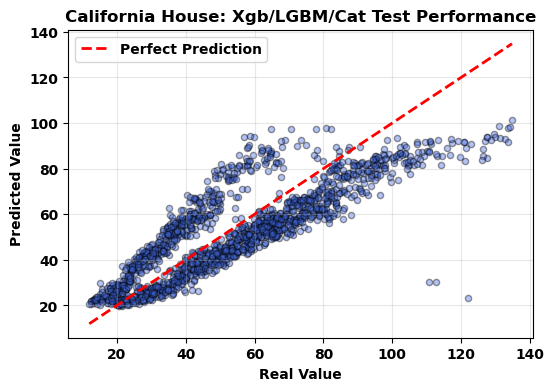

In [113]:
fig, ax = functions.get_prediction_graph({'California House: Xgb/LGBM/Cat':(None, y_pred_simple)}, y_test=y_test)

In [114]:
from sklearn.base import BaseEstimator, RegressorMixin, clone
from sklearn.model_selection import KFold
from sklearn.metrics import r2_score

from xgboost import XGBClassifier
from catboost import CatBoostRegressor


# ==========================================================
# 1. SMART SOFT MODEL SELECTOR – FIXED VERSION
# ==========================================================

class SmartSoftModelSelector(BaseEstimator, RegressorMixin):
    def __init__(self, estimators, selector_model=None, cv=5):
        self.estimators = estimators
        self.model_names = [name for name, _ in estimators]
        self.cv = cv
        
        self.selector_model = selector_model if selector_model else XGBClassifier(
            n_estimators=300,
            max_depth=6,
            learning_rate=0.05,
            device='cuda',
            tree_method='hist',
            n_jobs=1,
            random_state=42
        )

    def fit(self, X, y):
        X = pd.DataFrame(X).reset_index(drop=True)
        y = np.array(y)

        kf = KFold(n_splits=self.cv, shuffle=True, random_state=42)
        
        # OOF matrix: [n_samples, n_models]
        oof_preds = np.zeros((len(X), len(self.estimators)))

        print("\n=== Training Esperti con OOF ===")
        for m_idx, (name, model) in enumerate(self.estimators):
            print(f" -> {name}")
            for train_i, valid_i in kf.split(X):
                X_tr, X_val = X.iloc[train_i], X.iloc[valid_i]  # FIXED
                y_tr = y[train_i]
                
                model_fold = clone(model)
                model_fold.fit(X_tr, y_tr)
                oof_preds[valid_i, m_idx] = model_fold.predict(X_val)

        # Selettore target = il modello con errore minore per ciascun sample
        errors = np.abs(oof_preds - y.reshape(-1, 1))
        y_best = errors.argmin(axis=1)

        print("=== Training Gating Network ===")
        self.selector_model.fit(X, y_best)

        # Ora alleniamo definitivamente ogni esperto sul 100% del dataset
        print("=== Training Esperti Finali (100%) ===")
        self.fitted_estimators_ = []
        for name, model in self.estimators:
            m = clone(model)
            m.fit(X, y)
            self.fitted_estimators_.append(m)

        return self

    def predict(self, X):
        X = pd.DataFrame(X)
        base_preds = np.column_stack([m.predict(X) for m in self.fitted_estimators_])
        weights = self.selector_model.predict_proba(X)
        return np.sum(base_preds * weights, axis=1)



# ==========================================================
# 2. RESIDUAL CORRECTOR – FIXED VERSION
# ==========================================================

class ResidualCorrectedMoE(BaseEstimator, RegressorMixin):
    def __init__(self, base_moe_model, corrector_model=None, cv=5):
        self.base_moe_model = base_moe_model
        self.cv = cv
        
        self.corrector_model = corrector_model if corrector_model else CatBoostRegressor(
            iterations=500,
            depth=6,
            learning_rate=0.03,
            task_type='GPU',
            devices='0',
            verbose=0,
            random_state=42,
            allow_writing_files=False
        )

    def fit(self, X, y):
        X = pd.DataFrame(X).reset_index(drop=True)
        y = np.array(y)

        print("\n=== Calcolo Residui OOF del MoE ===")

        kf = KFold(n_splits=self.cv, shuffle=True, random_state=42)
        oof_preds = np.zeros(len(X))

        for train_i, valid_i in kf.split(X):
            X_tr, X_val = X.iloc[train_i], X.iloc[valid_i]  # FIXED
            y_tr = y[train_i]

            # clone MoE e retrain sul fold
            moe_fold = clone(self.base_moe_model)
            moe_fold.fit(X_tr, y_tr)
            oof_preds[valid_i] = moe_fold.predict(X_val)

        residuals = y - oof_preds
        print(f" Residual mean: {residuals.mean():.4f}")
        print(f" Residual std : {residuals.std():.4f}")

        print("\n=== Training Correttore Residui ===")
        self.corrector_model.fit(X, residuals)

        # salva modello MoE finale (train 100%)
        self.base_moe_model.fit(X, y)

        return self

    def predict(self, X):
        X = pd.DataFrame(X)
        base_pred = self.base_moe_model.predict(X)
        correction = self.corrector_model.predict(X)
        return base_pred + correction


In [115]:

# Creiamo e addestriamo il sistema MoE
moe_model = SmartSoftModelSelector(estimators=estimators)
moe_model.fit(X_train_scaled_df, y_train_full_log)

# ---------------------------------------------------------
# 6. AGGIUNTA DEL CORRETTORE DEI RESIDUI (Residual Learning)
# ---------------------------------------------------------
print("\n6. Training Correttore dei Residui...")
# Costruzione Finale
# Nota: passiamo il moe_model già addestrato, ma la classe ResidualCorrectedMoE
# userà cross_val_predict che internamente farà cloni e fit su fold.
final_system = ResidualCorrectedMoE(base_moe_model=moe_model)
final_system.fit(X_train_scaled_df, y_train_full_log)

# Valutazione
y_pred_log = final_system.predict(X_test_scaled_df)
y_pred = np.expm1(y_pred_log)

final_rmse = root_mean_squared_error(y_test, y_pred)
final_r2 = r2_score(y_test, y_pred)
# Plot veloce
corrections_test = final_system.corrector_model.predict(X_test_scaled_df)
base_preds_test = final_system.base_moe_model.predict(X_test_scaled_df)


=== Training Esperti con OOF ===
 -> xgb
 -> lgbm
 -> cat
=== Training Gating Network ===
=== Training Esperti Finali (100%) ===

6. Training Correttore dei Residui...

=== Calcolo Residui OOF del MoE ===

=== Training Esperti con OOF ===
 -> xgb
 -> lgbm
 -> cat
=== Training Gating Network ===
=== Training Esperti Finali (100%) ===

=== Training Esperti con OOF ===
 -> xgb
 -> lgbm
 -> cat
=== Training Gating Network ===
=== Training Esperti Finali (100%) ===

=== Training Esperti con OOF ===
 -> xgb
 -> lgbm
 -> cat
=== Training Gating Network ===
=== Training Esperti Finali (100%) ===

=== Training Esperti con OOF ===
 -> xgb
 -> lgbm
 -> cat
=== Training Gating Network ===
=== Training Esperti Finali (100%) ===

=== Training Esperti con OOF ===
 -> xgb
 -> lgbm
 -> cat
=== Training Gating Network ===
=== Training Esperti Finali (100%) ===
 Residual mean: -0.0019
 Residual std : 0.2599

=== Training Correttore Residui ===

=== Training Esperti con OOF ===
 -> xgb
 -> lgbm
 -> cat
=


 OOF Final Results
 RMSE: 13.96608
 R^2 : 0.69071


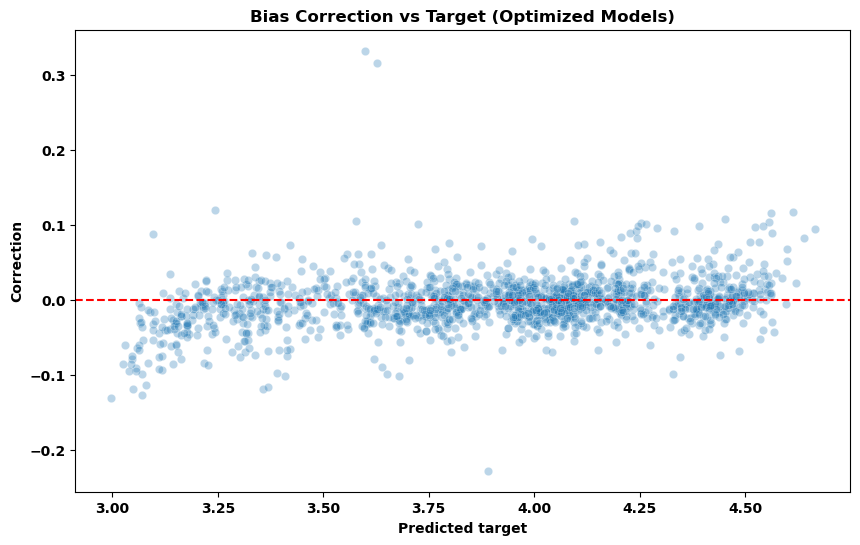

In [118]:
import matplotlib.pyplot as plt
import seaborn as sns

print(f"\n==========================================")
print(f" OOF Final Results")
print(f"==========================================")
print(f" RMSE: {final_rmse:.5f}")
print(f" R^2 : {final_r2:.5f}")
print(f"==========================================")

plt.figure(figsize=(10, 6))
sns.scatterplot(x=base_preds_test, y=corrections_test, alpha=0.3)
plt.axhline(0, color='red', linestyle='--')
plt.title("Bias Correction vs Target (Optimized Models)")
plt.xlabel("Predicted target")
plt.ylabel("Correction")
plt.show()

In [117]:
# Evaluate on training data
y_train_pred_log = final_system.predict(X_train_scaled_df)
y_train_pred = np.expm1(y_train_pred_log)
train_rmse = root_mean_squared_error(y_train, y_train_pred)
train_r2 = r2_score(y_train, y_train_pred)

print(f"\n=== TRAIN vs TEST COMPARISON ===")
print(f"Train RMSE: {train_rmse:.5f}")
print(f"Test  RMSE: {final_rmse:.5f}")
print(f"Train R²:   {train_r2:.5f}")
print(f"Test  R²:   {final_r2:.5f}")
print(f"RMSE Gap:   {abs(train_rmse - final_rmse):.5f}")
print(f"R² Gap:     {abs(train_r2 - final_r2):.5f}")


=== TRAIN vs TEST COMPARISON ===
Train RMSE: 12.67683
Test  RMSE: 13.96608
Train R²:   0.74256
Test  R²:   0.69071
RMSE Gap:   1.28925
R² Gap:     0.05185
